In [ ]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import os
import numpy as np
from tqdm import tqdm

# Torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.utils.data import random_split
from torchvision.models import resnet18
from PIL import Image as PILImage
from torchvision.datasets import ImageFolder
from torchvision.models import ResNet18_Weights

# Load ART dependencies:
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import ProjectedGradientDescent, ShadowAttack, CarliniL2Method, FeatureAdversariesPyTorch, DeepFool, AutoProjectedGradientDescent, HopSkipJump, PixelAttack
from art.defences.preprocessor import SpatialSmoothing, Mixup, FeatureSqueezing
from art.defences.trainer import AdversarialTrainerFBFPyTorch
from art.utils import to_categorical

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
N_CLASSES = 5
DATASET_PATH = '/mnt/ssd1t/datasets/imagenet100/imagenet_100'
# PRETRAINED_MODEL_PATH = "./data/resnet18_imagenet100.pth"
# PRETRAINED_MODEL_PATH = './data/resnet18_imagenet100_adv_carlini_l2_mix.pth'
PRETRAINED_MODEL_PATH = "./data/resnet18_avengers_face.pth"
#PRETRAINED_MODEL_PATH = "./data/resnet18_avengers_adv_carlini_l2_mix.pth"

In [ ]:
# TODO add train code for learn dataset classes
# TODO save imagenet100 splitted in train and val (avoid splitting in the code every time) 
# TODO Refactor Defences section

# Utils

In [9]:
def get_resnet18_classifier(n_classes, pretrained, device, criterion, optimizer_args, weight_path=None):
    model = resnet18(pretrained)
    model.fc = nn.Linear(model.fc.in_features, n_classes)
    if weight_path is not None:
        model.load_state_dict(torch.load(weight_path, map_location=torch.device("cpu")))
    model = model.to(device)
    classifier = PyTorchClassifier(
        model=model,
        clip_values=(0, 255),
        loss=criterion,
        optimizer=optim.SGD(model.parameters(), **optimizer_args),
        input_shape=(3, 224, 224),  # ResNet18 expects input shape (C, H, W)
        nb_classes=n_classes,
        #preprocessing=preprocessor
    )
    transform = ResNet18_Weights.IMAGENET1K_V1.transforms()
    return model, classifier, transform

In [40]:
# Convert train_dataset to numpy arrays (images and labels)
def convert_to_numpy(dataset):
    images_np = []
    labels_np = []

    for img, label in tqdm(dataset):
        # img is a torch.Tensor (C, H, W), convert to numpy and transpose to (H, W, C)
        #img_np = img.numpy().transpose(1, 2, 0)
        images_np.append(img)
        labels_np.append(label)

    images_np = np.stack(images_np)
    labels_np = np.array(labels_np)

    #print('Images shape:', images_np.shape)
    #print('Labels shape:', labels_np.shape)
    return images_np, labels_np

In [11]:
# TODO: do it with dataoader torch, and remove the previous function
def generate_adv_batch(images, adv, batch_size=32, labels=None):
    img_adv=[]
    for i in tqdm(range(0, len(images), batch_size)):
        batch_images = images[i:i+batch_size]
        if labels is None:
            x_adv = adv.generate(batch_images)
        else:
            batch_labels = labels[i:i+batch_size]
            # x_adv = adv.generate(batch_images, y=to_categorical(batch_labels, nb_classes=100))
            x_adv = adv.generate(batch_images, y=batch_labels)

        img_adv.append(x_adv)

    img_adv = np.concatenate(img_adv, axis=0)
    return img_adv

In [12]:
def save_dataset(og_img_list, adv_img_list, labels, save_dir):
    """Create dataset for discriminate original - adv images"""

    os.makedirs(save_dir, exist_ok=True)
    og_dir = os.path.join(save_dir, "og")
    og_np_dir = os.path.join(save_dir, "og_np")
    adv_dir = os.path.join(save_dir, "adv")
    adv_np_dir = os.path.join(save_dir, "adv_np")
    os.makedirs(og_np_dir, exist_ok=True)
    os.makedirs(adv_np_dir, exist_ok=True)
    os.makedirs(og_dir, exist_ok=True)
    os.makedirs(adv_dir, exist_ok=True)

    assert og_img_list.shape[0] == adv_img_list.shape[0], "Original and adversarial images must have the same number of samples."

    for i in tqdm(range(og_img_list.shape[0])):
        # Convert (C, H, W) to (H, W, C) and scale to [0,255]
        og_img = og_img_list[i].transpose(1, 2, 0)
        adv_img = adv_img_list[i].transpose(1, 2, 0)
        og_img = np.clip(og_img, 0, 1)
        adv_img = np.clip(adv_img, 0, 1)
        og_img = (og_img * 255).astype(np.uint8)
        adv_img = (adv_img * 255).astype(np.uint8)
        og_img_pil = PILImage.fromarray(og_img)
        adv_img_pil = PILImage.fromarray(adv_img)
        og_img_pil.save(os.path.join(og_dir, f"{i:05d}.png"))
        adv_img_pil.save(os.path.join(adv_dir, f"{i:05d}.png"))

        np.save(os.path.join(og_np_dir, f"{i:05d}.npy"), og_img_list[i])
        np.save(os.path.join(adv_np_dir, f"{i:05d}.npy"), adv_img_list[i])



    
    labels_path = os.path.join(save_dir, "labels_og_adv.npy")
    np.save(labels_path, labels)

In [13]:
def train_classifier(model, optimizer, criterion, device, train_loader, num_epochs):
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.4f}")
    
    return model

In [14]:
class ImageFolderWithNumpyLabels(Dataset):
    def __init__(self, images_dir, labels_path=None, label=None, transform=None):
        self.images_dir = images_dir
        self.transform = transform
        self.label = label
        self.image_files = sorted(os.listdir(images_dir))
        if labels_path:
            self.labels = np.load(labels_path)
            assert len(self.image_files) == len(self.labels), "Number of images and labels must match"
       
       
    def __len__(self):
        return len(self.image_files) #len(self.labels)

    def __getitem__(self, idx):
        img_np = np.load(os.path.join(self.images_dir, self.image_files[idx]))
        # if self.transform:
        #     image = self.transform(image)
        if self.label is not None:
            label = self.label
        else:
            label = int(self.labels[idx])
        
        return torch.Tensor(img_np), label

# Load Model

In [ ]:
model, classifier, transform = get_resnet18_classifier(
    n_classes=N_CLASSES,
    pretrained=True,
    device=device,
    criterion=nn.CrossEntropyLoss(),
    optimizer_args={
        'lr': 0.0001,
        'momentum': 0.9,
        'weight_decay': 1e-4
    },
    weight_path=PRETRAINED_MODEL_PATH
)

# Create Adversarial dataset
Note: Images are normalized (imgnet meand and std)

In [22]:
dataset = ImageFolder(root=DATASET_PATH, transform=transform)

In [13]:
images_np, labels_np = convert_to_numpy(dataset)

100%|██████████| 5000/5000 [00:28<00:00, 175.70it/s]


Images shape: (5000, 3, 224, 224)
Labels shape: (5000,)


In [ ]:
subset_samples = 100
images_np_subset = images_np[:subset_samples]
labels_np_subset = labels_np[:subset_samples]

## White-Box

#### PDG Untargeted

In [ ]:
adv = ProjectedGradientDescent(classifier, targeted=False, batch_size=32, max_iter=20, eps_step=0.001, eps=5, decay=0.9)

In [ ]:
images_adv_np = generate_adv_batch(images_np, adv, batch_size=32)

100%|██████████| 157/157 [07:30<00:00,  2.87s/it]


In [ ]:
save_dataset(images_np, images_adv_np, labels_np, "/mnt/ssd1t/datasets/imagenet_100_adv/")

100%|██████████| 5000/5000 [02:30<00:00, 33.18it/s]


#### PGD Targeted (random label)


In [ ]:
adv = ProjectedGradientDescent(classifier, targeted=True, batch_size=32, max_iter=20, eps_step=0.001, eps=5, decay=0.9)

In [ ]:
random_labels_np = np.random.randint(0, 100, size=labels_np.shape)

In [ ]:
images_adv_np = generate_adv_batch(images_np, adv, batch_size=32, labels=random_labels_np)

100%|██████████| 157/157 [07:12<00:00,  2.75s/it]


In [ ]:
save_dataset(images_np, images_adv_np, labels_np, "/mnt/ssd1t/datasets/imagenet_100_adv_random_targeted/")

100%|██████████| 5000/5000 [02:26<00:00, 34.04it/s]


#### Shadow Attack Untargeted

In [ ]:
adv = ShadowAttack(classifier, targeted=False, sigma=0.01, nb_steps=1000, learning_rate=0.2, lambda_tv=0.3, lambda_c=1.0, lambda_s=0.5, batch_size=1, verbose=False)

In [60]:
images_adv_np = generate_adv_batch(images_np, adv, batch_size=1)

100%|██████████| 1/1 [00:14<00:00, 14.50s/it]


In [61]:
save_dataset(images_np, images_adv_np, labels_np, "/mnt/ssd1t/datasets/imagenet_100_adv_shadow/")

100%|██████████| 1/1 [00:00<00:00, 40.57it/s]


#### Carlini L2 Untargeted

In [ ]:
adv = CarliniL2Method(classifier, confidence=0.0, targeted=False, learning_rate=0.01, 
                      binary_search_steps=10, max_iter=10, initial_const=0.01, max_halving=5, max_doubling=5, batch_size=1  )

In [45]:
images_adv_np = generate_adv_batch(images_np_subset, adv, batch_size=1)

100%|██████████| 7/7 [11:37<00:00, 99.69s/it] 


In [47]:
save_dataset(images_np_subset, images_adv_np, labels_np_subset, "/mnt/ssd1t/datasets/imagenet_100_adv_carlini_l2/")

100%|██████████| 100/100 [00:02<00:00, 41.35it/s]


#### FeatureAdversariesPyTorch

In [13]:
images_np.shape[0]

5000

In [14]:
guide_image = images_np[496]
guide_images_np = np.stack([guide_image] * images_np_subset.shape[0])

In [15]:
adv = FeatureAdversariesPyTorch(classifier, delta=1.0, optimizer=None, lambda_=0.0, layer=-1, max_iter=100, batch_size=8, step_size=0.01, random_start=False)

In [ ]:
# TODO scegliere immagini di label diverse wrt l input
images_adv_np = generate_adv_batch(images_np_subset, adv, batch_size=8, labels=guide_images_np)

  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [01:24<00:00,  6.51s/it]


In [17]:
save_dataset(images_np_subset, images_adv_np, labels_np_subset, "/mnt/ssd1t/datasets/imagenet_100_adv_FA/")

100%|██████████| 100/100 [00:02<00:00, 42.07it/s]


#### DeepFool 

In [ ]:
adv = DeepFool(classifier, max_iter=100, epsilon=1e-6, nb_grads=20, batch_size=1, verbose=False)

In [ ]:
images_adv_np = generate_adv_batch(images_np_subset, adv, batch_size=1, labels=labels_np_subset)

100%|██████████| 3/3 [00:07<00:00,  2.60s/it]


In [99]:
save_dataset(images_np_subset, images_adv_np, labels_np_subset, "/mnt/ssd1t/datasets/imagenet_100_adv_deepfool/")

100%|██████████| 10/10 [00:00<00:00, 33.49it/s]


#### Auto PGD Untargeted

In [27]:
adv = AutoProjectedGradientDescent(classifier, norm="inf", eps=0.3, eps_step=0.1, max_iter=100, 
                                   targeted=False, nb_random_init=5, batch_size=1, loss_type="cross_entropy", verbose=False)

In [ ]:
images_adv_np = generate_adv_batch(images_np_subset, adv, batch_size=1)

In [83]:
save_dataset(images_np_subset, images_adv_np, labels_np_subset, "/mnt/ssd1t/datasets/imagenet_100_adv_autopgd/")

100%|██████████| 10/10 [00:00<00:00, 39.15it/s]


## Black-Box

#### HopSkipJump (Untargeted)

In [21]:
adv = HopSkipJump(classifier, batch_size=1, targeted=False, norm="inf", max_iter=50, max_eval=10000, init_eval=100, init_size=100, verbose=False )

In [30]:
images_adv_np = generate_adv_batch(images_np_subset.astype(np.float32), adv, batch_size=1)

100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


In [31]:
save_dataset(images_np_subset, images_adv_np, labels_np_subset, "/mnt/ssd1t/datasets/imagenet_100_adv_HSJ/")

100%|██████████| 10/10 [00:00<00:00, 40.70it/s]


#### PixelAttack (Untargeted)

In [50]:
adv = PixelAttack(classifier, th=None, es=1, max_iter=100, targeted=False, verbose=False)

In [52]:
images_adv_np = generate_adv_batch(images_np_subset, adv, batch_size=1)

100%|██████████| 25/25 [15:32<00:00, 37.28s/it]


In [60]:
save_dataset(images_np_subset, images_adv_np, labels_np_subset, "/mnt/ssd1t/datasets/imagenet_100_adv_PA/")

100%|██████████| 100/100 [00:02<00:00, 45.55it/s]


# Load adv dataset

In [ ]:
# images_dir = "/mnt/ssd1t/datasets/imagenet_100_adv_PA/"
# #img_targeted_dir = "/mnt/ssd1t/datasets/imagenet_100_adv_random_targeted/"
# labels_path = "/mnt/ssd1t/datasets/imagenet_100_adv_PA/labels_og_adv.npy"

# dataset_og_norm = ImageFolderWithNumpyLabels(os.path.join(images_dir, 'og_np'), labels_path)
# dataset_adv_norm = ImageFolderWithNumpyLabels(os.path.join(images_dir, 'adv_np'), labels_path)
# #dataset_adv_norm_targeted = ImageFolderWithNumpyLabels(os.path.join(img_targeted_dir, 'adv_np'), labels_path)

# train_size = int(0.8 * len(dataset_og_norm))
# val_size = len(dataset_og_norm) - train_size

# torch.manual_seed(42)
# train_dataset_og, val_dataset_og = random_split(dataset_og_norm, [train_size, val_size])
# torch.manual_seed(42)
# train_dataset_adv, val_dataset_adv = random_split(dataset_adv_norm, [train_size, val_size])
# #torch.manual_seed(42)
# #train_dataset_adv_targeted, val_dataset_adv_targeted = random_split(dataset_adv_norm_targeted, [train_size, val_size])

In [16]:
# Validation
images_dir = "/mnt/ssd1t/datasets/avengers_face/adv_carlini"
labels_path = "/mnt/ssd1t/datasets/avengers_face/adv_carlini/labels_og_adv.npy"
val_dataset_og = ImageFolderWithNumpyLabels(os.path.join(images_dir, 'og_np'), labels_path)
val_dataset_adv = ImageFolderWithNumpyLabels(os.path.join(images_dir, 'adv_np'), labels_path)

# Train
labels_path = "/mnt/ssd1t/datasets/avengers_face/train_adv_carlini/labels_og_adv.npy"
images_dir = "/mnt/ssd1t/datasets/avengers_face/train_adv_carlini"
train_dataset_og = ImageFolderWithNumpyLabels(os.path.join(images_dir, 'og_np'), labels_path)
train_dataset_adv = ImageFolderWithNumpyLabels(os.path.join(images_dir, 'adv_np'), labels_path)

In [17]:
train_aug = ConcatDataset([train_dataset_og, train_dataset_adv])
#train_aug = ConcatDataset([train_dataset_og, train_dataset_adv, train_dataset_adv_targeted])
train_loader_aug = DataLoader(train_aug, batch_size=32, shuffle=True)
val_aug = ConcatDataset([val_dataset_adv, val_dataset_og])
val_loader_aug = DataLoader(val_aug, batch_size=32, shuffle=False)

# Defences

## Train with adv images

In [72]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)
model = train_classifier(model, optimizer, criterion, device, train_loader_aug, num_epochs=10)

100%|██████████| 18/18 [00:02<00:00,  7.09it/s]


Epoch 1/10 - Loss: 1.2651 - Accuracy: 0.5730


100%|██████████| 18/18 [00:02<00:00,  7.78it/s]


Epoch 2/10 - Loss: 1.1827 - Accuracy: 0.6588


100%|██████████| 18/18 [00:02<00:00,  8.06it/s]


Epoch 3/10 - Loss: 1.1112 - Accuracy: 0.7190


100%|██████████| 18/18 [00:02<00:00,  7.92it/s]


Epoch 4/10 - Loss: 1.0487 - Accuracy: 0.7172


100%|██████████| 18/18 [00:02<00:00,  7.61it/s]


Epoch 5/10 - Loss: 0.9659 - Accuracy: 0.7883


100%|██████████| 18/18 [00:02<00:00,  7.90it/s]


Epoch 6/10 - Loss: 0.9159 - Accuracy: 0.8066


100%|██████████| 18/18 [00:02<00:00,  7.68it/s]


Epoch 7/10 - Loss: 0.8461 - Accuracy: 0.8449


100%|██████████| 18/18 [00:02<00:00,  7.98it/s]


Epoch 8/10 - Loss: 0.8000 - Accuracy: 0.8613


100%|██████████| 18/18 [00:02<00:00,  7.64it/s]


Epoch 9/10 - Loss: 0.7572 - Accuracy: 0.8814


100%|██████████| 18/18 [00:02<00:00,  7.83it/s]

Epoch 10/10 - Loss: 0.7060 - Accuracy: 0.8960


In [73]:
# Save model
model_path = "./data/resnet18_avengers_adv_carlini_l2_mix.pth"
# model_path = "./data/resnet18_imagenet100_adv_FA_mix.pth"
torch.save(model.state_dict(), model_path)

In [21]:
# Load model
model_path = "./data/resnet18_imagenet100_adv_carlini_l2_mix.pth"
model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))

<All keys matched successfully>

## SpatialSmoothing

In [25]:
val_images_og_np, val_lbl_og_np = convert_to_numpy(val_dataset_og)
val_images_adv_np, val_lbl_adv_np = convert_to_numpy(val_dataset_adv)

100%|██████████| 20/20 [00:00<00:00, 4921.45it/s]


Images shape: (20, 3, 224, 224)
Labels shape: (20,)


100%|██████████| 20/20 [00:00<00:00, 4961.03it/s]

Images shape: (20, 3, 224, 224)
Labels shape: (20,)


In [28]:
# Initialize the SpatialSmoothing defence. 
ss = SpatialSmoothing(window_size=3)

# Apply the defence to the original input and to the adversarial sample, respectively:
x_art_def, _ = ss(val_images_og_np)
x_art_adv_def, _ = ss(val_images_adv_np)

# Compute the classifier predictions on the preprocessed inputs:
pred_def = classifier.predict(x_art_def)
label_def = np.argmax(pred_def, axis=1)
#confidence_def = pred_def[:, label_def][0]

pred_adv_def = classifier.predict(x_art_adv_def)
label_adv_def = np.argmax(pred_adv_def, axis=1)
#confidence_adv_def = pred_adv_def[:, label_adv_def][0]

pred_adv_no_def = classifier.predict(val_images_adv_np)
label_adv_no_def = np.argmax(pred_adv_no_def, axis=1)
#confidence_adv_def = pred_adv_def[:, label_adv_def][0]

print("Preds with og image preprocessed:\n", label_def)
print("Preds with adv image preprocessed:\n", label_adv_def)
print("Preds with adv image:\n", label_adv_no_def)
# Print the predictions:
# print('Prediction of original sample:', (label_def), '- confidence {0:.2f}'.format(confidence_def))
# print('Prediction of adversarial sample:', (label_adv_def), 
#       '- confidence {0:.2f}'.format(confidence_adv_def))

# Show the preprocessed adversarial sample:
#plt.figure(figsize=(8,8)); plt.imshow(x_art_adv_def[0] / 255); plt.axis('off'); plt.show()

Preds with og image preprocessed:
 [99  1  0  1  0  1  0  0  1  1  0  1  0  1  1  0  0  1  0  0]
Preds with adv image preprocessed:
 [23  1 72  1  0  1  6 75  1  1 99  1  0  1  1  0 90  1 23  0]
Preds with adv image:
 [99  1 72 72  6 20 22 47 83  1 99  7  0 72  1  0 20 20 23 23]


In [ ]:
# GT
val_lbl_og_np

array([0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0])

## MixUp

In [19]:
val_images_og_np, val_lbl_og_np = convert_to_numpy(val_dataset_og)
val_images_adv_np, val_lbl_adv_np = convert_to_numpy(val_dataset_adv)

100%|██████████| 20/20 [00:00<00:00, 5198.37it/s]


Images shape: (20, 3, 224, 224)
Labels shape: (20,)


100%|██████████| 20/20 [00:00<00:00, 4145.18it/s]

Images shape: (20, 3, 224, 224)
Labels shape: (20,)


In [20]:
# Initialize the SpatialSmoothing defence. 

mp = Mixup(num_classes=100, alpha=1.0, num_mix=2, apply_fit=True, apply_predict=False)

# Apply the defence to the original input and to the adversarial sample, respectively:
x_art_def, _ = mp(val_images_og_np, val_lbl_og_np)
x_art_adv_def, _ = mp(val_images_adv_np, val_lbl_adv_np)

# Compute the classifier predictions on the preprocessed inputs:
pred_def = classifier.predict(x_art_def.astype(np.float32))
label_def = np.argmax(pred_def, axis=1)

pred_adv_def = classifier.predict(x_art_adv_def.astype(np.float32))
label_adv_def = np.argmax(pred_adv_def, axis=1)

pred_adv_no_def = classifier.predict(val_images_adv_np)
label_adv_no_def = np.argmax(pred_adv_no_def, axis=1)

print(label_def)
print(label_adv_def)
print(label_adv_no_def)

[0 1 1 0 0 1 0 0 1 1 1 0 0 1 1 1 0 0 0 0]
[ 0  9  9  9  9  9  1  9  9  9  9  9  9  9 83  0  1  9 83  9]
[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.8799999].


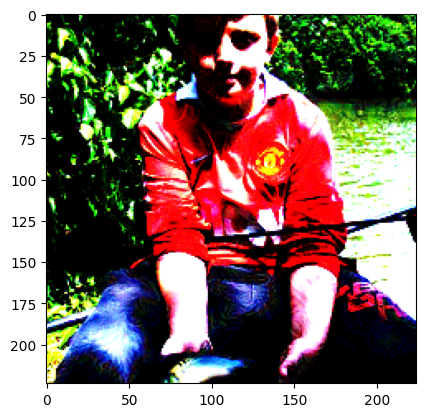

In [61]:
plt.imshow(val_images_adv_np[0].transpose(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.633011091081834].


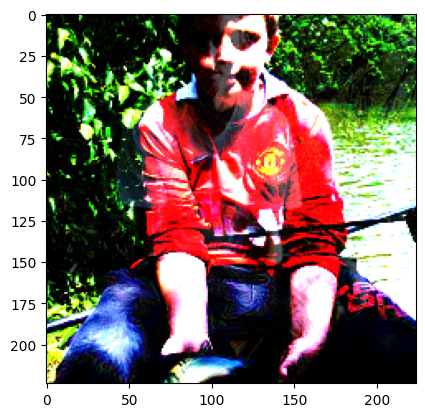

In [62]:
plt.imshow(x_art_adv_def[0].transpose(1, 2, 0))

## Feature Squeezing

In [21]:
val_images_og_np, val_lbl_og_np = convert_to_numpy(val_dataset_og)
val_images_adv_np, val_lbl_adv_np = convert_to_numpy(val_dataset_adv)

100%|██████████| 20/20 [00:00<00:00, 4911.65it/s]


Images shape: (20, 3, 224, 224)
Labels shape: (20,)


100%|██████████| 20/20 [00:00<00:00, 4467.25it/s]

Images shape: (20, 3, 224, 224)
Labels shape: (20,)


In [22]:
# Initialize the SpatialSmoothing defence. 

# (val_images_og_np.min(), val_images_og_np.max())
mp = FeatureSqueezing(clip_values=(0, 1), bit_depth=8)

# Apply the defence to the original input and to the adversarial sample, respectively:
x_art_def, _ = mp(val_images_og_np, val_lbl_og_np)
x_art_adv_def, _ = mp(val_images_adv_np, val_lbl_adv_np)

# TODO check cast f64 to f32
pred_def = classifier.predict(x_art_def.astype(np.float32))
label_def = np.argmax(pred_def, axis=1)

pred_adv_def = classifier.predict(x_art_adv_def.astype(np.float32))
label_adv_def = np.argmax(pred_adv_def, axis=1)

pred_adv_no_def = classifier.predict(val_images_adv_np)
label_adv_no_def = np.argmax(pred_adv_no_def, axis=1)

print(label_def)
print(label_adv_def)
print(label_adv_no_def)

[0 1 0 1 0 1 0 0 1 1 0 1 0 1 1 0 0 1 0 0]
[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.8784313725490196].


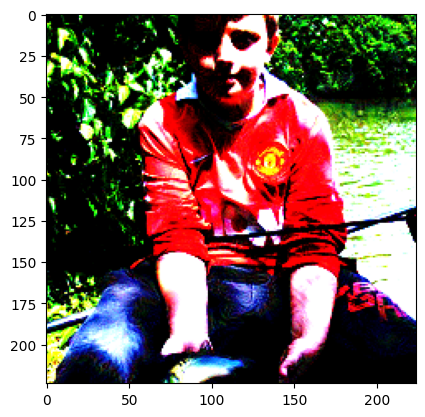

In [51]:
plt.imshow(x_art_adv_def[0].transpose(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.8799999].


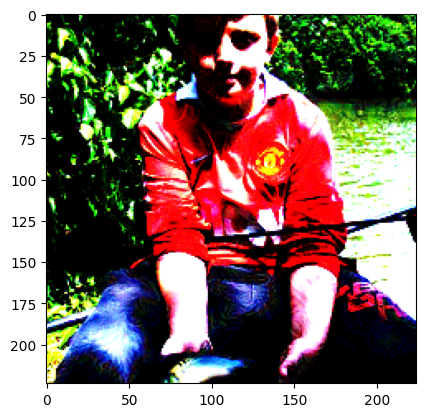

In [52]:
plt.imshow(val_images_adv_np[0].transpose(1, 2, 0))

## Fast is Better then Free

In [23]:
adv_train = AdversarialTrainerFBFPyTorch(classifier, eps=8, use_amp=False)

In [14]:
train_og_np, train_og_lbl_np = convert_to_numpy(train_dataset_og)
val_og_np, val_og_lbl_np = convert_to_numpy(val_dataset_og)

100%|██████████| 80/80 [00:00<00:00, 2086.15it/s]


Images shape: (80, 3, 224, 224)
Labels shape: (80,)


100%|██████████| 20/20 [00:00<00:00, 3416.11it/s]

Images shape: (20, 3, 224, 224)
Labels shape: (20,)


In [24]:
train_og_np = images_np[:1000]
train_og_lbl_np = labels_np[:1000]

In [26]:
#val_og_lbl_np_onehot = to_categorical(val_og_lbl_np, nb_classes=100)
train_og_lbl_np_onehot = to_categorical(train_og_lbl_np, nb_classes=100)

In [27]:
adv_train.fit(x=train_og_np, y=train_og_lbl_np_onehot, nb_epochs=10, batch_size=8) # validation_data=(val_og_np, val_og_lbl_np_onehot)

Adversarial Training FBF - Epochs: 100%|██████████| 10/10 [01:40<00:00, 10.06s/it]


In [34]:
classifier = adv_train.get_classifier()

# Eval

In [41]:
def evaluation(model, classifier, dataset_og, dataset_adv):
    # Original
    test_dataloader = DataLoader(dataset_og, batch_size=32, shuffle=False)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(test_dataloader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    og_acc = correct / total
    
    # Adv
    test_adv_np, test_lbl_np = convert_to_numpy(dataset_adv)
    pred_adv = classifier.predict(test_adv_np)
    label_adv = np.argmax(pred_adv, axis=1)
    adv_acc = np.sum(label_adv == test_lbl_np) / test_lbl_np.shape[0]
    del pred_adv, label_adv, test_adv_np, test_lbl_np

    # Original + Adv
    test_dataset_aug = ConcatDataset([dataset_og, dataset_adv])
    test_aug_np, test_lbl_aug_np = convert_to_numpy(test_dataset_aug)
    pred_adv = classifier.predict(test_aug_np)
    label_adv = np.argmax(pred_adv, axis=1)
    aug_acc = np.sum(label_adv == test_lbl_aug_np) / test_lbl_aug_np.shape[0]

    return og_acc, adv_acc, aug_acc

In [46]:
# Model fine tuned on avengers original
#evaluation(model, classifier, train_dataset_og, train_dataset_adv)
og_acc, adv_acc, aug_acc = evaluation(model, classifier, val_dataset_og, val_dataset_adv)
print(f"Dataset Original Accuracy: {og_acc:.4f}")
print('Dataset Adversarial Accuracy:', adv_acc)
print('Dataset Og+Adv Accuracy:', aug_acc)

100%|██████████| 120/120 [00:00<00:00, 4509.52it/s]


Dataset Original Accuracy: 0.9000
Dataset Adversarial Accuracy: 0.5
Dataset Og+Adv Accuracy: 0.7


In [43]:
# Model trained on carlini mix 
#evaluation(model, classifier, train_dataset_og, train_dataset_adv)
og_acc, adv_acc, aug_acc = evaluation(model, classifier, val_dataset_og, val_dataset_adv)
print(f"Dataset Original Accuracy: {og_acc:.4f}")
print('Dataset Adversarial Accuracy:', adv_acc)
print('Dataset Og+Adv Accuracy:', aug_acc)

100%|██████████| 120/120 [00:00<00:00, 5558.68it/s]


Dataset Original Accuracy: 0.9833
Dataset Adversarial Accuracy: 0.9
Dataset Og+Adv Accuracy: 0.9416666666666667


## Splitted

### Original

In [80]:
test_dataloader = DataLoader(val_dataset_og, batch_size=32, shuffle=False)

In [83]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(test_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")

100%|██████████| 2/2 [00:00<00:00, 21.07it/s]

Test Accuracy: 0.9000


### adv

In [76]:
val_images_np, val_lbl_np = convert_to_numpy(val_dataset_adv)

100%|██████████| 60/60 [00:00<00:00, 5243.97it/s]

Images shape: (60, 3, 224, 224)
Labels shape: (60,)


In [84]:
pred_adv = classifier.predict(val_images_np)
label_adv = np.argmax(pred_adv, axis=1)
acc = np.sum(label_adv == val_lbl_np) / val_lbl_np.shape[0]
print('Accuracy of adversarial samples:', acc)

Accuracy of adversarial samples: 0.5


### og + adv

In [67]:
val_images_aug_np, val_lbl_aug_np = convert_to_numpy(val_aug)

100%|██████████| 40/40 [00:00<00:00, 4804.06it/s]

Images shape: (40, 3, 224, 224)
Labels shape: (40,)


In [68]:
pred_adv = classifier.predict(val_images_aug_np)
label_adv = np.argmax(pred_adv, axis=1)
acc = np.sum(label_adv == val_lbl_aug_np) / val_lbl_aug_np.shape[0]
print('Accuracy of adversarial samples:', acc)

Accuracy of adversarial samples: 0.55


## Metrics

### CLEVER

In [10]:
from art.metrics import clever_u

In [ ]:
#clever_u_score = clever_u(classifier, images_np[0], verbose=True, nb_batches=1024, batch_size=500, radius=5, norm=np.inf)
clever_u_score = clever_u(classifier, images_np[5], verbose=True, nb_batches=2, batch_size=2, radius=5, norm=2, pool_factor=1, c_init=1)

In [37]:
clever_u_score # Naive

np.float64(0.5982268759557977)

In [ ]:
clever_u_score # Fine tuned

np.float64(0.9319811006964296)

# Module to predict adv images

In [7]:
images_dir = "/mnt/ssd1t/datasets/imagenet100/imagenet_100_adv_carlini_l2/"
labels_path = "/mnt/ssd1t/datasets/imagenet100/imagenet_100_adv_carlini_l2/labels_og_adv.npy"

dataset_og_norm = ImageFolderWithNumpyLabels(os.path.join(images_dir, 'og_np'), label=0)
dataset_adv_norm = ImageFolderWithNumpyLabels(os.path.join(images_dir, 'adv_np'), label=1)

train_size = int(0.8 * len(dataset_og_norm))
val_size = len(dataset_og_norm) - train_size

torch.manual_seed(42)
train_dataset_og, val_dataset_og = random_split(dataset_og_norm, [train_size, val_size])
torch.manual_seed(42)
train_dataset_adv, val_dataset_adv = random_split(dataset_adv_norm, [train_size, val_size])

In [8]:
train_aug = ConcatDataset([train_dataset_og, train_dataset_adv])
train_loader_aug = DataLoader(train_aug, batch_size=32, shuffle=True)
val_aug = ConcatDataset([val_dataset_og, val_dataset_adv])
val_loader_aug = DataLoader(val_aug, batch_size=32, shuffle=False)

## Train naive model (resnet pretrained on imagenet-100)

In [100]:
model = resnet18(pretrained=True)
#model_path = "./resnet18_imagenet100.pth"
#model.fc = nn.Linear(model.fc.in_features, 100)
#model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
model.fc = nn.Linear(model.fc.in_features, 2)

In [101]:
# Freeze all layers except the classifier (head)
for name, param in model.named_parameters():
    if name.startswith("fc"):
        param.requires_grad = True
    else:
        param.requires_grad = False

In [102]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)

# Training loop
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader_aug):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.4f}")

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 16.86it/s]


Epoch 1/20 - Loss: 0.7174 - Accuracy: 0.5437


100%|██████████| 5/5 [00:00<00:00, 16.09it/s]


Epoch 2/20 - Loss: 0.6848 - Accuracy: 0.5813


100%|██████████| 5/5 [00:00<00:00, 21.83it/s]


Epoch 3/20 - Loss: 0.6811 - Accuracy: 0.5938


100%|██████████| 5/5 [00:00<00:00, 21.74it/s]


Epoch 4/20 - Loss: 0.6546 - Accuracy: 0.6188


100%|██████████| 5/5 [00:00<00:00, 21.83it/s]


Epoch 5/20 - Loss: 0.6826 - Accuracy: 0.5687


100%|██████████| 5/5 [00:00<00:00, 21.58it/s]


Epoch 6/20 - Loss: 0.6502 - Accuracy: 0.6312


100%|██████████| 5/5 [00:00<00:00, 16.78it/s]


Epoch 7/20 - Loss: 0.6492 - Accuracy: 0.6375


100%|██████████| 5/5 [00:00<00:00, 21.79it/s]


Epoch 8/20 - Loss: 0.6377 - Accuracy: 0.6375


100%|██████████| 5/5 [00:00<00:00,  9.06it/s]


Epoch 9/20 - Loss: 0.6216 - Accuracy: 0.6625


100%|██████████| 5/5 [00:00<00:00, 21.87it/s]


Epoch 10/20 - Loss: 0.6026 - Accuracy: 0.6875


100%|██████████| 5/5 [00:00<00:00, 21.81it/s]


Epoch 11/20 - Loss: 0.6151 - Accuracy: 0.6687


100%|██████████| 5/5 [00:00<00:00, 19.01it/s]


Epoch 12/20 - Loss: 0.6023 - Accuracy: 0.7125


100%|██████████| 5/5 [00:00<00:00, 19.53it/s]


Epoch 13/20 - Loss: 0.5990 - Accuracy: 0.6875


100%|██████████| 5/5 [00:00<00:00, 21.83it/s]


Epoch 14/20 - Loss: 0.5935 - Accuracy: 0.7250


100%|██████████| 5/5 [00:00<00:00, 21.83it/s]


Epoch 15/20 - Loss: 0.5862 - Accuracy: 0.7188


100%|██████████| 5/5 [00:00<00:00, 21.81it/s]


Epoch 16/20 - Loss: 0.5814 - Accuracy: 0.7188


100%|██████████| 5/5 [00:00<00:00, 21.78it/s]


Epoch 17/20 - Loss: 0.5683 - Accuracy: 0.7250


100%|██████████| 5/5 [00:00<00:00, 17.85it/s]


Epoch 18/20 - Loss: 0.5609 - Accuracy: 0.7438


100%|██████████| 5/5 [00:00<00:00, 21.22it/s]


Epoch 19/20 - Loss: 0.5641 - Accuracy: 0.7500


100%|██████████| 5/5 [00:00<00:00, 21.91it/s]

Epoch 20/20 - Loss: 0.5573 - Accuracy: 0.7500


In [103]:
val_images_aug_np, val_lbl_aug_np = convert_to_numpy(val_aug)

100%|██████████| 40/40 [00:00<00:00, 4821.45it/s]

Images shape: (40, 3, 224, 224)
Labels shape: (40,)


In [104]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)

classifier = PyTorchClassifier(
    model=model,
    clip_values=(0, 255),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 224, 224),  # ResNet18 expects input shape (C, H, W)
    nb_classes=2,
    #preprocessing=preprocessor
    )

In [105]:
pred_adv = classifier.predict(val_images_aug_np)
print(pred_adv.shape)
label_adv = np.argmax(pred_adv, axis=1)
acc = np.sum(label_adv == val_lbl_aug_np) / val_lbl_aug_np.shape[0]
print('Accuracy of adversarial samples:', acc)

(40, 2)
Accuracy of adversarial samples: 0.7


## Binary Input Detector

In [9]:
from art.defences.detector.evasion import BinaryInputDetector

In [10]:
model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)

In [117]:
# Freeze all layers except the classifier (head)
for name, param in model.named_parameters():
    if name.startswith("fc"):
        param.requires_grad = True
    else:
        param.requires_grad = False

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)

detector_classifier = PyTorchClassifier(
    model=model,
    clip_values=(0, 255),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 224, 224),  # ResNet18 expects input shape (C, H, W)
    nb_classes=2,
    #preprocessing=preprocessor
)

In [13]:
detector = BinaryInputDetector(detector_classifier)

In [14]:
train_img, train_lbl = convert_to_numpy(train_aug)
train_lbl_cat = to_categorical(train_lbl, nb_classes=2)

100%|██████████| 160/160 [00:00<00:00, 2376.75it/s]

Images shape: (160, 3, 224, 224)
Labels shape: (160,)


In [15]:
detector.fit(x=train_img, y=train_lbl_cat, nb_epochs=20, batch_size=2)

In [16]:
pred = detector.detect(x=train_img)

In [17]:
acc = (pred[1] == train_lbl).sum() / len(train_lbl)
print(f"Detection accuracy: {acc:.4f}")

Detection accuracy: 0.8500


In [18]:
val_img, val_lbl = convert_to_numpy(val_aug)

100%|██████████| 40/40 [00:00<00:00, 406.18it/s]

Images shape: (40, 3, 224, 224)
Labels shape: (40,)


In [19]:
pred = detector.detect(x=val_img)
acc = (pred[1] == val_lbl).sum() / len(val_lbl)
print(f"Detection accuracy: {acc:.4f}")

Detection accuracy: 0.8250


## BinaryActivationDetector

In [21]:
from art.defences.detector.evasion import BinaryActivationDetector

In [27]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, in_channels=64, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc = nn.Linear(32 * 56 * 56, num_classes)  # assuming input size (64, 224, 224)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)  # output: (16, 112, 112)
        x = F.relu(self.conv2(x))
        x = self.fc(x.view(x.size(0), -1))  # flatten and apply linear layer
        return x

In [28]:
model = SimpleCNN(in_channels=64, num_classes=2)
#model = resnet18(pretrained=True)
#model.fc = nn.Linear(model.fc.in_features, 2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [29]:
classifier = resnet18(pretrained=True)
classifier.fc = nn.Linear(classifier.fc.in_features, 100)
model_path = "./data/resnet18_imagenet100.pth"
classifier.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
classifier = classifier.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)

classifier = PyTorchClassifier(
    model=classifier,
    clip_values=(0, 255),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 224, 224),  # ResNet18 expects input shape (C, H, W)
    nb_classes=100,
    #preprocessing=preprocessor
)

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)

detector_classifier = PyTorchClassifier(
    model=model,
    clip_values=(0, 255),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 224, 224),  # ResNet18 expects input shape (C, H, W)
    nb_classes=2,
    #preprocessing=preprocessor
)

In [ ]:
# With Layer 0, better result wrt binary input detector
detector = BinaryActivationDetector(classifier, detector_classifier, layer=0)

In [15]:
train_img, train_lbl = convert_to_numpy(train_aug)
#train_lbl_cat = to_categorical(train_lbl, nb_classes=2)

100%|██████████| 160/160 [00:00<00:00, 2948.25it/s]

Images shape: (160, 3, 224, 224)
Labels shape: (160,)


In [ ]:
detector.fit(x=train_img, y=train_lbl, nb_epochs=20, batch_size=2)

In [18]:
pred = detector.detect(x=train_img)

In [19]:
acc = (pred[1] == train_lbl).sum() / len(train_lbl)
print(f"Detection accuracy: {acc:.4f}")

Detection accuracy: 0.8438


In [37]:
val_img, val_lbl = convert_to_numpy(val_aug)
pred = detector.detect(x=val_img)
acc = (pred[1] == val_lbl).sum() / len(val_lbl)
print(f"Detection accuracy: {acc:.4f}")

100%|██████████| 40/40 [00:00<00:00, 4447.36it/s]

Images shape: (40, 3, 224, 224)
Labels shape: (40,)
Detection accuracy: 0.8250


# Real world (Face recognition)

In [54]:
from torchvision.models import ResNet18_Weights
transform = ResNet18_Weights.IMAGENET1K_V1.transforms()

In [55]:
dataset_root = '/mnt/ssd1t/datasets/avengers_face/images'

In [56]:
model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [58]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# Example usage:
dataset = ImageFolder(os.path.join(dataset_root, "train"), transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
# val_dataset_og = ImageFolder(os.path.join(dataset_root, "val"), transform=transform)

In [59]:
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

In [60]:
num_epochs = 10
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.4f}")

Epoch 1/10 - Loss: 1.8277 - Accuracy: 0.2007
Epoch 2/10 - Loss: 1.7011 - Accuracy: 0.1934
Epoch 3/10 - Loss: 1.5850 - Accuracy: 0.2774
Epoch 4/10 - Loss: 1.4899 - Accuracy: 0.3504
Epoch 5/10 - Loss: 1.4141 - Accuracy: 0.4343
Epoch 6/10 - Loss: 1.3322 - Accuracy: 0.5620
Epoch 7/10 - Loss: 1.2797 - Accuracy: 0.6095
Epoch 8/10 - Loss: 1.2034 - Accuracy: 0.6606
Epoch 9/10 - Loss: 1.1417 - Accuracy: 0.7555
Epoch 10/10 - Loss: 1.0853 - Accuracy: 0.7810


In [ ]:
#torch.save(model.state_dict(), "./data/resnet18_avengers_face.pth")

In [ ]:
#model.load_state_dict(torch.load("./data/resnet18_avengers_face.pth", map_location=torch.device("cpu")))

<All keys matched successfully>

In [62]:
classifier = PyTorchClassifier(
    model=model,
    clip_values=(0, 255),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 224, 224),  # ResNet18 expects input shape (C, H, W)
    nb_classes=5,
    #preprocessing=preprocessor
)

In [63]:
adv = CarliniL2Method(classifier, confidence=0.0, targeted=False, learning_rate=0.01, 
                      binary_search_steps=10, max_iter=10, initial_const=0.01, max_halving=5, max_doubling=5, batch_size=1  )

In [64]:
images_np, labels_np = convert_to_numpy(dataset)

100%|██████████| 274/274 [00:01<00:00, 220.46it/s]

Images shape: (274, 3, 224, 224)
Labels shape: (274,)


In [ ]:
# images_np_subset = images_np[:20]
# labels_np_subset = labels_np[:20]

In [65]:
images_adv_np = generate_adv_batch(images_np, adv, batch_size=1)

100%|██████████| 274/274 [21:21<00:00,  4.68s/it]


In [67]:
save_dataset(images_np, images_adv_np, labels_np, "/mnt/ssd1t/datasets/avengers_face/train_adv_carlini/")

100%|██████████| 274/274 [00:07<00:00, 36.93it/s]
